          1. VISTAZO INICIAL AL DATASET


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600000,0.627000,50,1
1,1,85,66,29,0,26.600000,0.351000,31,0
2,8,183,64,0,0,23.300000,0.672000,32,1
3,1,89,66,23,94,28.100000,0.167000,21,0
4,0,137,40,35,168,43.100000,2.288000,33,1



     2. DESCRIPCION ESTADISTICA DE LOS DATOS


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.000000,120.894531,31.972618,0.000000,99.000000,117.000000,140.250000,199.000000
BloodPressure,768.000000,69.105469,19.355807,0.000000,62.000000,72.000000,80.000000,122.000000
SkinThickness,768.000000,20.536458,15.952218,0.000000,0.000000,23.000000,32.000000,99.000000
Insulin,768.000000,79.799479,115.244002,0.000000,0.000000,30.500000,127.250000,846.000000
BMI,768.000000,31.992578,7.884160,0.000000,27.300000,32.000000,36.600000,67.100000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000



          ANALISIS DE VALORES FALTANTES Y CEROS


,Valores Nulos (NaN),Valores Cero (0)
Pregnancies,0,111
Glucose,0,5
BloodPressure,0,35
SkinThickness,0,227
Insulin,0,374
BMI,0,11
DiabetesPedigreeFunction,0,0
Age,0,0



--- Informacion general y tipos de datos ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


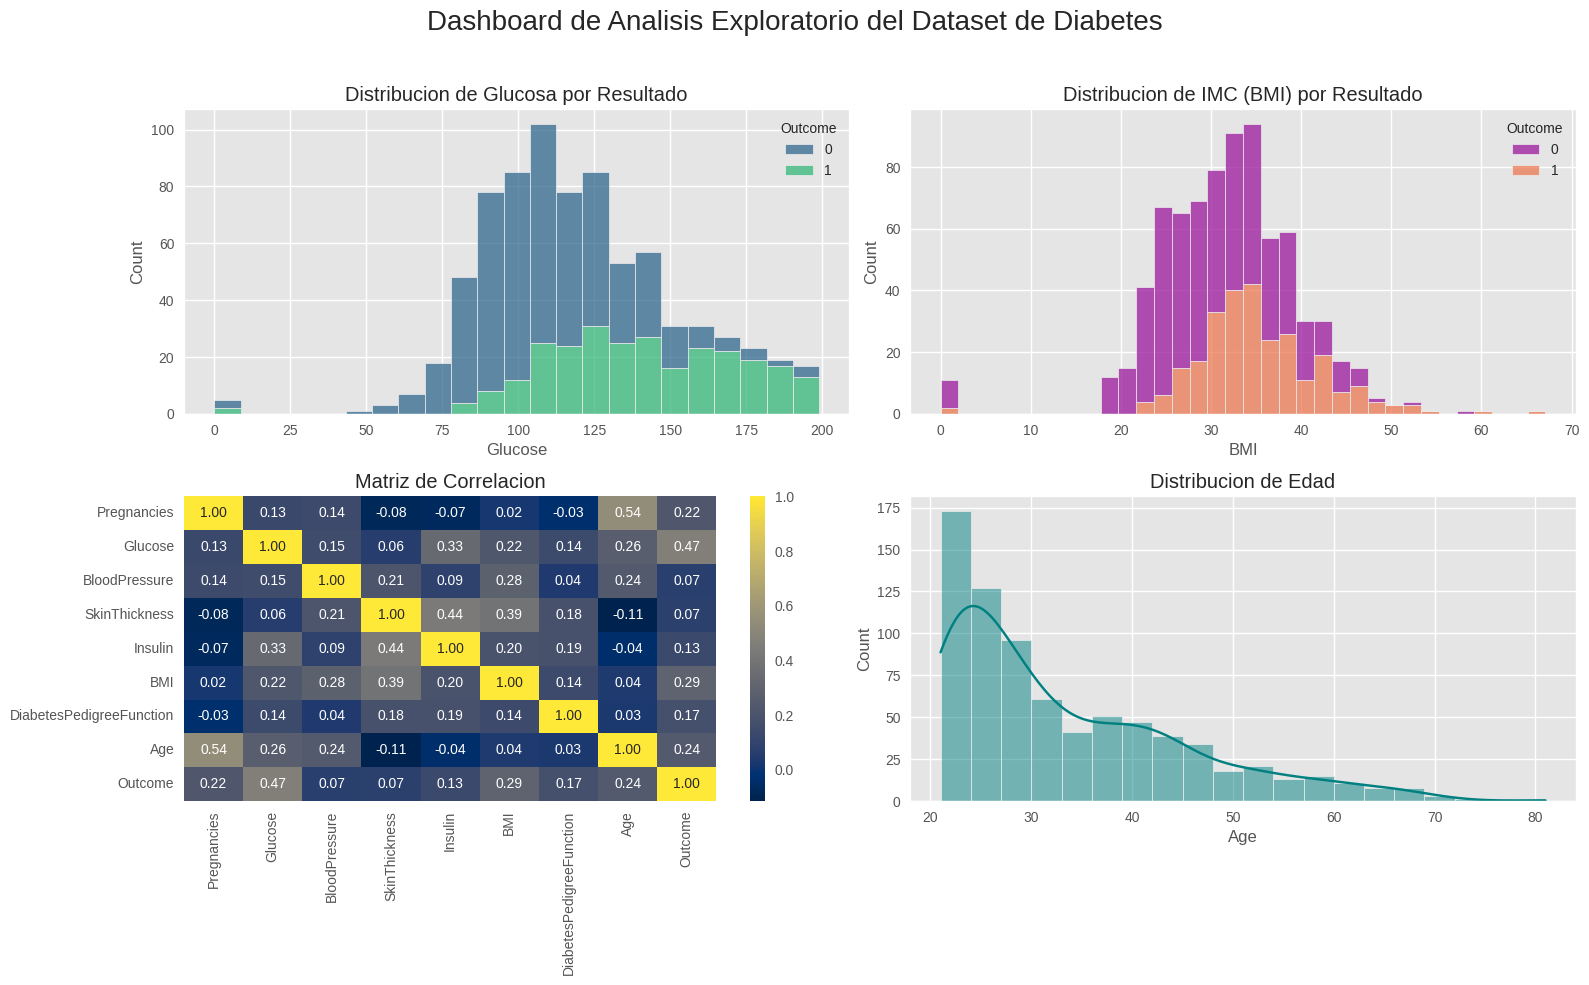

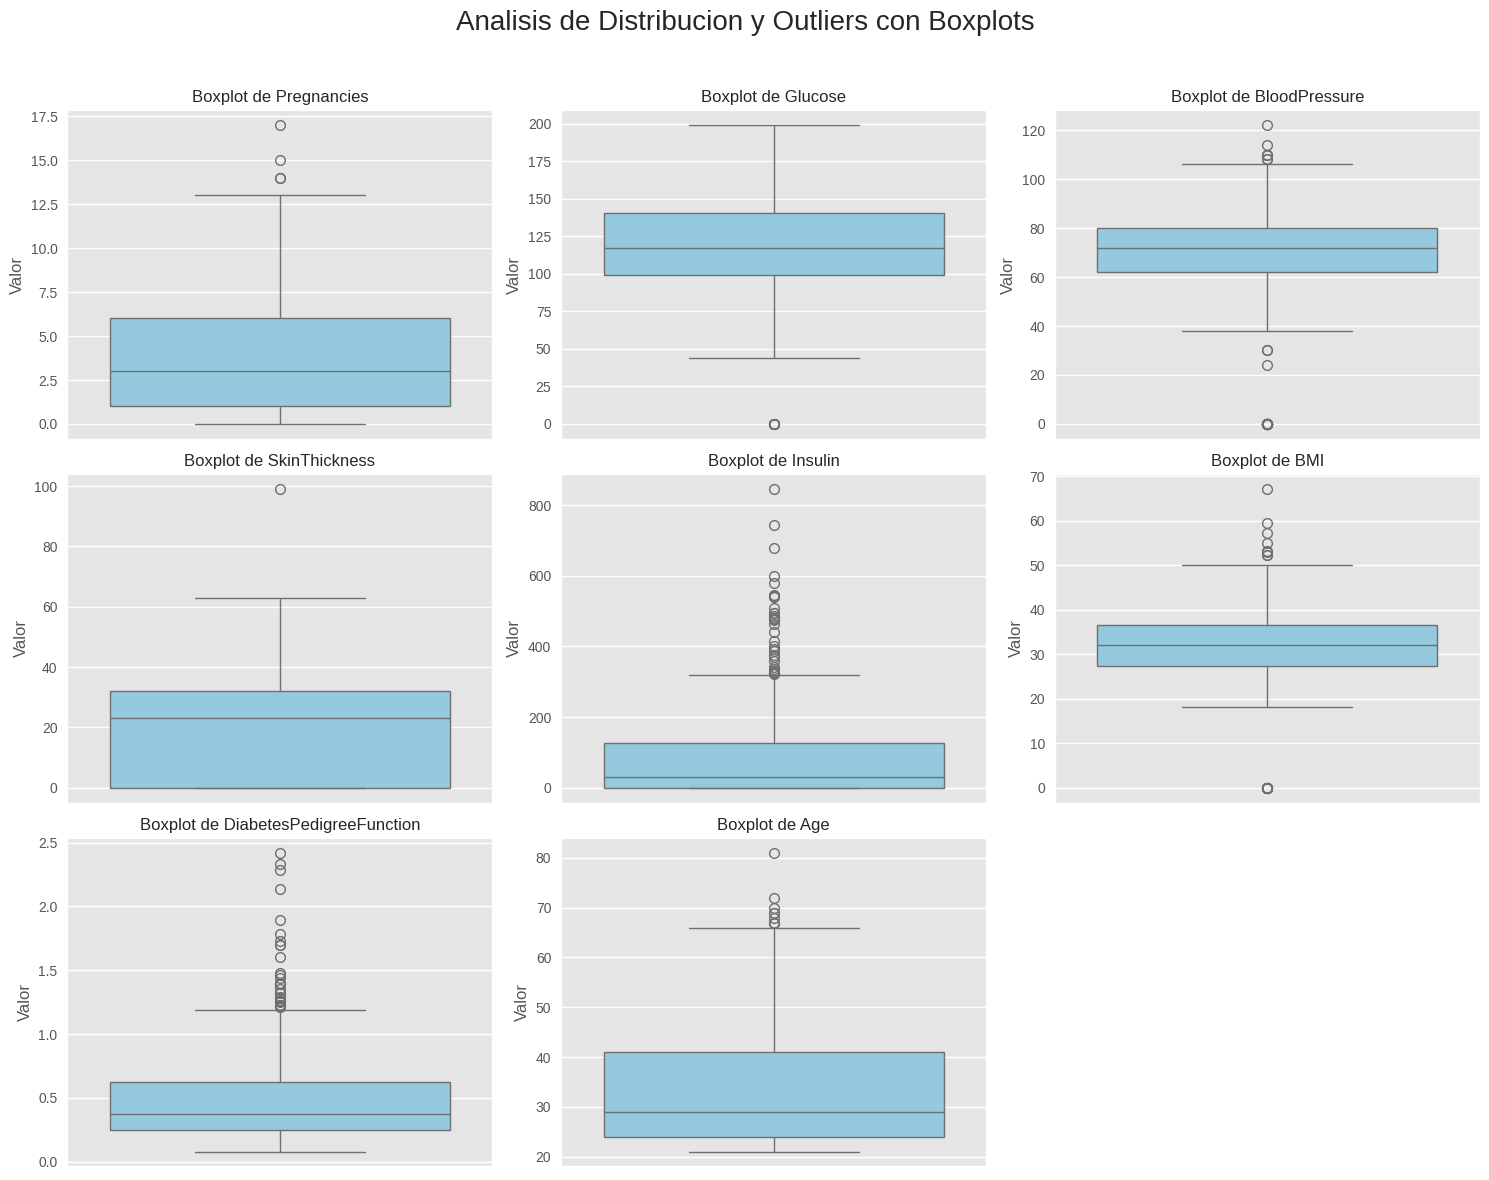

In [46]:
# 1. Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
from IPython.display import display


# 2. Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/ULP-UGD/Programacion_Avanzada/refs/heads/main/TP14/diabetes.csv')


# --- 1. Exploracion de Datos ---
print("="*50)
print(" "*10 + "1. VISTAZO INICIAL AL DATASET")
print("="*50)
display(df.head().style.set_caption("Primeras 5 filas del dataset"))

print("\n" + "="*50)
print(" "*5 + "2. DESCRIPCION ESTADISTICA DE LOS DATOS")
print("="*50)
stats = df.describe().T
styled_describe = stats.style.background_gradient(
    cmap='coolwarm',
    subset=['mean', 'std', 'min', '25%', '50%', '75%', 'max']
).set_caption("Estadisticas descriptivas")
display(styled_describe)

print("\n" + "="*50)
print(" "*10 + "ANALISIS DE VALORES FALTANTES Y CEROS")
print("="*50)
null_counts = df.isnull().sum()
zero_counts = (df == 0).sum()
missing_data_df = pd.DataFrame({
    'Valores Nulos (NaN)': null_counts,
    'Valores Cero (0)': zero_counts
})
missing_data_df = missing_data_df.drop('Outcome')
styled_missing_data = missing_data_df.style.background_gradient(cmap='Reds')
display(styled_missing_data)

print("\n--- Informacion general y tipos de datos ---")
df.info()


# --- Visualizaciones Exploratorias ---

# Dashboard de Visualizacion
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Dashboard de Analisis Exploratorio del Dataset de Diabetes', fontsize=20)

sns.histplot(data=df, x='Glucose', hue='Outcome', multiple='stack', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Distribucion de Glucosa por Resultado')

sns.histplot(data=df, x='BMI', hue='Outcome', multiple='stack', ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Distribucion de IMC (BMI) por Resultado')

sns.heatmap(df.corr(), annot=True, cmap='cividis', fmt='.2f', ax=axes[1, 0])
axes[1, 0].set_title('Matriz de Correlacion')

sns.histplot(df['Age'], kde=True, ax=axes[1, 1], bins=20, color='teal')
axes[1, 1].set_title('Distribucion de Edad')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Boxplots para deteccion de outliers
feature_columns = df.columns[:-1]
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Analisis de Distribucion y Outliers con Boxplots', fontsize=20)
axes = axes.flatten()

for i, column in enumerate(feature_columns):
    sns.boxplot(y=df[column], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot de {column}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Valor')

axes[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



        IMPACTO DEL REEMPLAZO DE CEROS


,Caracteristica,Ceros Reemplazados,Mediana
0,Glucose,5,117.00
1,BloodPressure,35,72.00
2,SkinThickness,227,29.00
3,Insulin,374,125.00
4,BMI,11,32.30



--- Visualizacion del cambio en la distribucion de datos ---


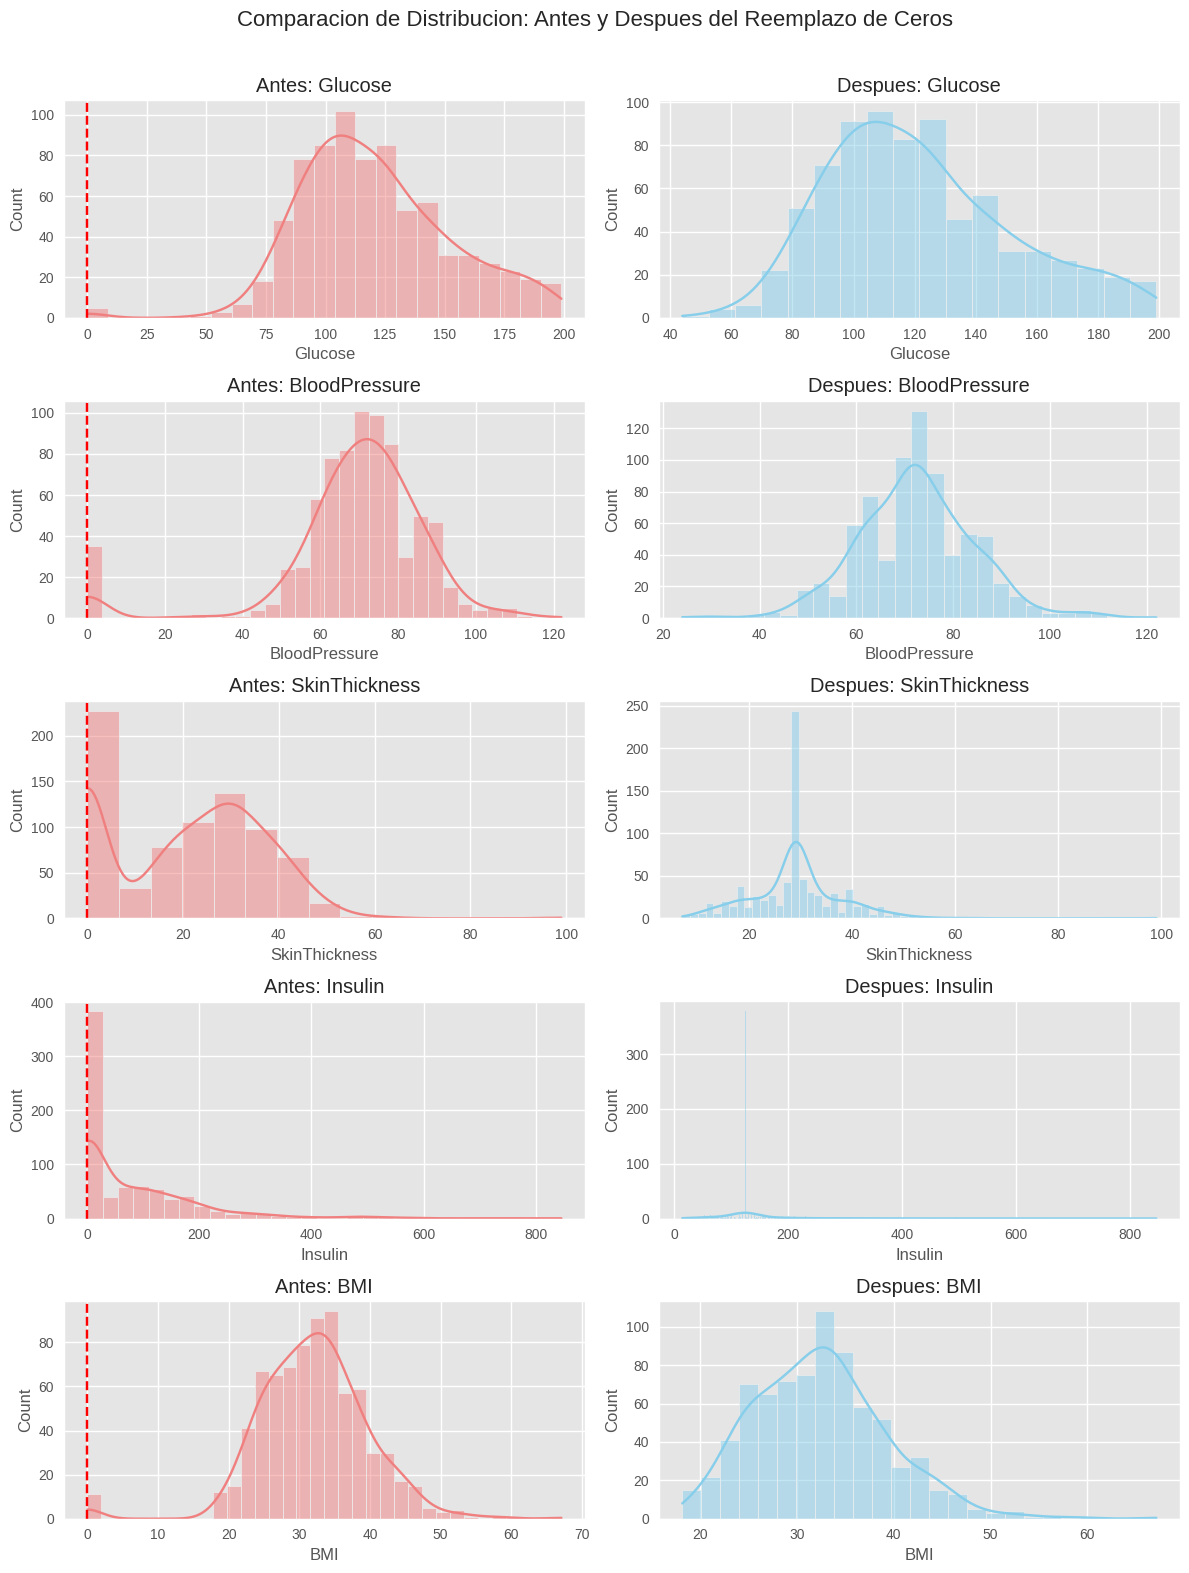

In [47]:
# --- 2. PREPROCESAMIENTO DE DATOS: LIMPIEZA DE CEROS ---
print("\n" + "="*60)
print(" "*8 + "IMPACTO DEL REEMPLAZO DE CEROS")
print("="*60)

columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_antes = df.copy()
summary_data = []

for col in columns_to_replace:
    median_val = df[df[col] != 0][col].median()
    zeros_antes = (df_antes[col] == 0).sum()
    df[col] = df[col].replace(0, median_val)
    summary_data.append([col, zeros_antes, f"{median_val:.2f}"])

summary_df = pd.DataFrame(summary_data, columns=[
    'Caracteristica',
    'Ceros Reemplazados',
    'Mediana'
])

display(summary_df.style.set_caption("Resumen del Impacto del Reemplazo de Ceros por la Mediana")
                      .background_gradient(cmap='Greens', subset=['Mediana']))

print("\n--- Visualizacion del cambio en la distribucion de datos ---")
fig, axes = plt.subplots(len(columns_to_replace), 2, figsize=(12, 16))
fig.suptitle('Comparacion de Distribucion: Antes y Despues del Reemplazo de Ceros', fontsize=16)

for i, col in enumerate(columns_to_replace):
    sns.histplot(df_antes[col], ax=axes[i, 0], kde=True, color='lightcoral')
    axes[i, 0].set_title(f'Antes: {col}')
    axes[i, 0].axvline(0, color='red', linestyle='--', label='Ceros')
    sns.histplot(df[col], ax=axes[i, 1], kde=True, color='skyblue')
    axes[i, 1].set_title(f'Despues: {col}')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


          NORMALIZACION Y DIVISION DE DATOS

--- Visualizacion de la Division del Dataset ---


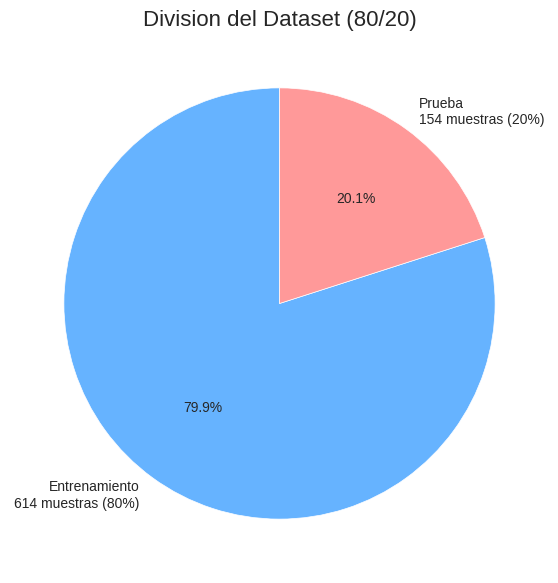

In [48]:
# --- 3. PREPROCESAMIENTO: NORMALIZACION Y DIVISION ---
print("\n" + "="*60)
print(" "*10 + "NORMALIZACION Y DIVISION DE DATOS")
print("="*60)

X = df.drop('Outcome', axis=1)
y = df['Outcome']

scaler = StandardScaler()
X_normado = scaler.fit_transform(X)
X_normado_df = pd.DataFrame(X_normado, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_normado_df, y, test_size=0.2, random_state=42)

print("\n--- Visualizacion de la Division del Dataset ---")
sizes = [X_train.shape[0], X_test.shape[0]]
labels = [f'Entrenamiento\n{sizes[0]} muestras ({sizes[0]/len(df):.0%})',
          f'Prueba\n{sizes[1]} muestras ({sizes[1]/len(df):.0%})']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'],
        wedgeprops={'edgecolor': 'white'})
plt.title('Division del Dataset (80/20)', fontsize=16)
plt.show()

In [49]:
# --- 4. Entrenamiento de Modelos ---
print("\n" + "="*60)
print(" "*12 + "ENTRENAMIENTO DE MODELOS")
print("="*60)

log_reg = LogisticRegression(random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)
rand_forest = RandomForestClassifier(random_state=42)

log_reg.fit(X_train, y_train)
dec_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

print("\n✓ Modelos entrenados exitosamente: Regresion Logistica, Arbol de Decision, Bosque Aleatorio.")


            ENTRENAMIENTO DE MODELOS

✓ Modelos entrenados exitosamente: Regresion Logistica, Arbol de Decision, Bosque Aleatorio.



     DASHBOARD DE EVALUACION Y COMPARACION DE MODELOS


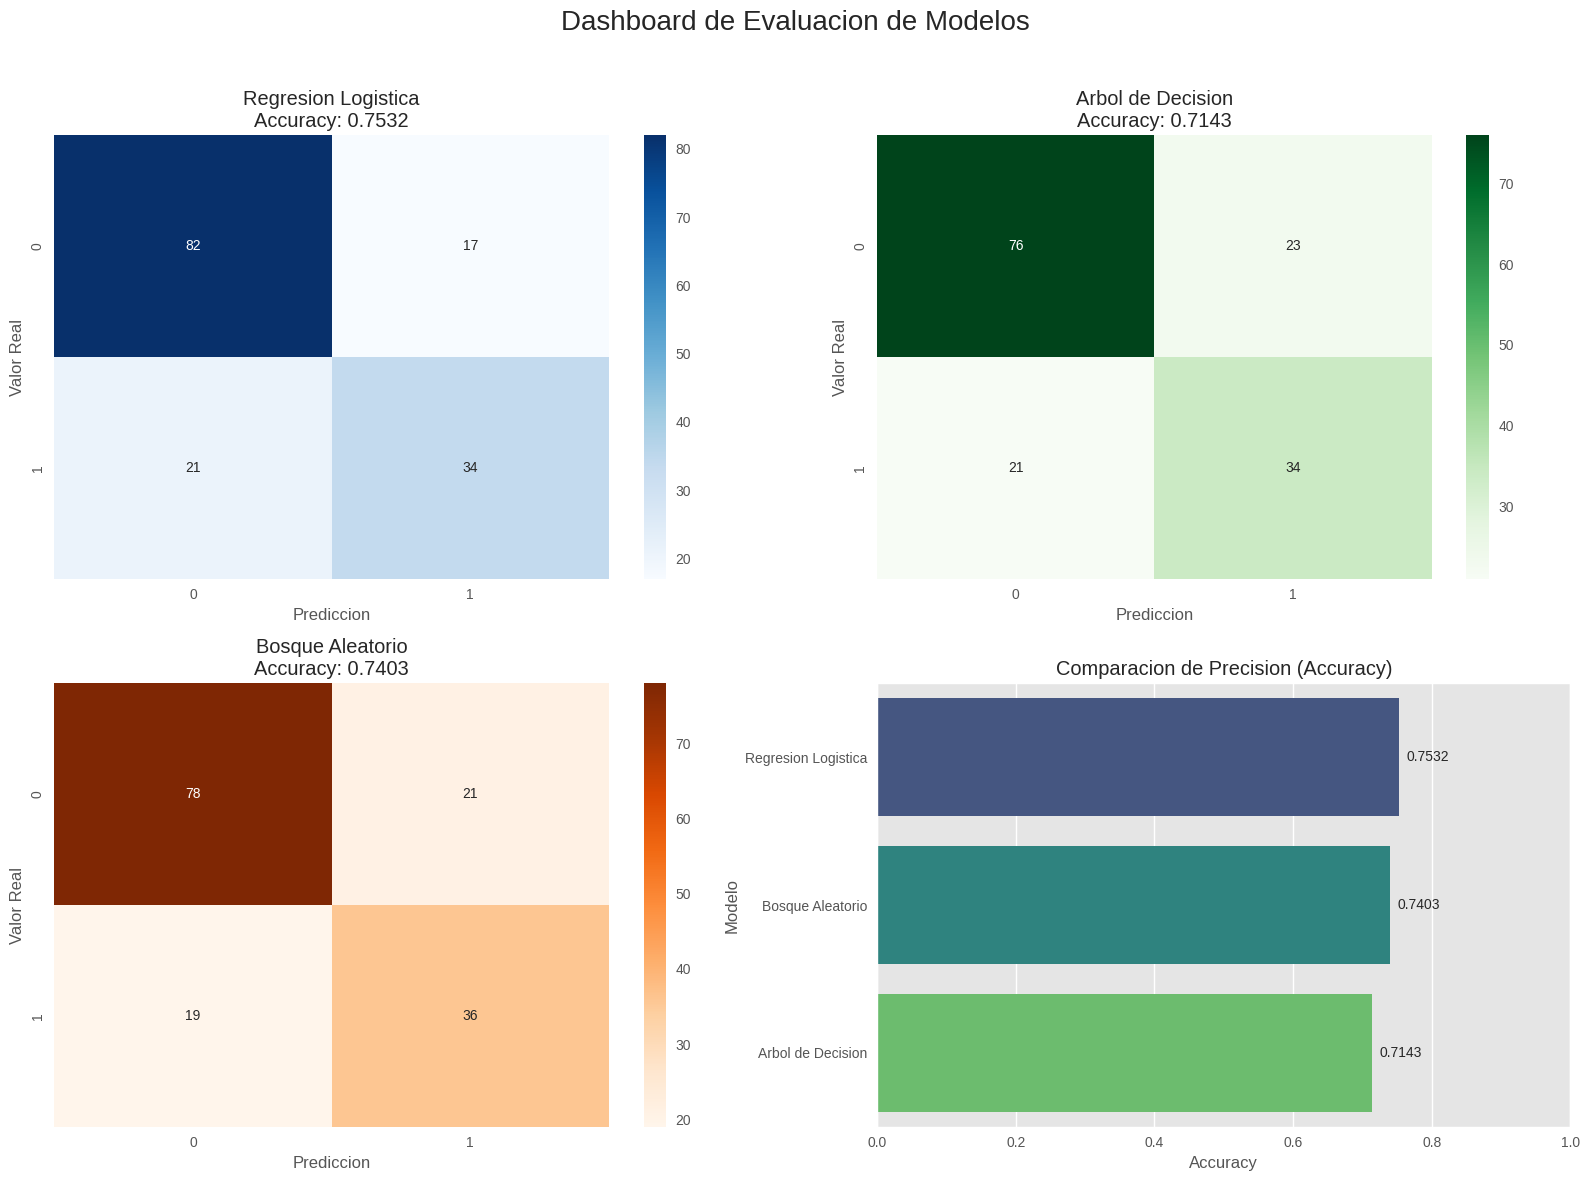

In [50]:
# --- 5. EVALUACION Y COMPARACION DE MODELOS ---
print("\n" + "="*60)
print(" "*5 + "DASHBOARD DE EVALUACION Y COMPARACION DE MODELOS")
print("="*60)

y_pred_log_reg = log_reg.predict(X_test)
y_pred_dec_tree = dec_tree.predict(X_test)
y_pred_rand_forest = rand_forest.predict(X_test)

acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
acc_dec_tree = accuracy_score(y_test, y_pred_dec_tree)
acc_rand_forest = accuracy_score(y_test, y_pred_rand_forest)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Dashboard de Evaluacion de Modelos', fontsize=20)

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Regresion Logistica\nAccuracy: {acc_log_reg:.4f}')
axes[0, 0].set_xlabel('Prediccion')
axes[0, 0].set_ylabel('Valor Real')

cm_dec_tree = confusion_matrix(y_test, y_pred_dec_tree)
sns.heatmap(cm_dec_tree, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1])
axes[0, 1].set_title(f'Arbol de Decision\nAccuracy: {acc_dec_tree:.4f}')
axes[0, 1].set_xlabel('Prediccion')
axes[0, 1].set_ylabel('Valor Real')

cm_rand_forest = confusion_matrix(y_test, y_pred_rand_forest)
sns.heatmap(cm_rand_forest, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0])
axes[1, 0].set_title(f'Bosque Aleatorio\nAccuracy: {acc_rand_forest:.4f}')
axes[1, 0].set_xlabel('Prediccion')
axes[1, 0].set_ylabel('Valor Real')

resultados = pd.DataFrame({
    'Modelo': ['Regresion Logistica', 'Arbol de Decision', 'Bosque Aleatorio'],
    'Accuracy': [acc_log_reg, acc_dec_tree, acc_rand_forest]
}).sort_values(by='Accuracy', ascending=False)

sns.barplot(x='Accuracy', y='Modelo', data=resultados, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Comparacion de Precision (Accuracy)')
axes[1, 1].set_xlim(0, 1.0)

for p in axes[1, 1].patches:
    width = p.get_width()
    axes[1, 1].text(width + 0.01, p.get_y() + p.get_height() / 2,
                    f'{width:.4f}', va='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [53]:
# --- 6. Exportación del Modelo ---
import joblib

print("\n" + "="*60)
print(" "*12 + "EXPORTACIÓN DEL PAQUETE COMPLETO")
print("="*60)

# Crear un diccionario para empaquetar el modelo y el escalador juntos
paquete_modelo = {
    'model': log_reg,  # El objeto del modelo de regresión logística
    'scaler': scaler    # El objeto StandardScaler que usaste para normalizar
}

# Guardar el diccionario completo en un único archivo
nombre_archivo = 'modelo_diabetes.pkl'
joblib.dump(paquete_modelo, nombre_archivo)

print(f"\nPaquete con modelo y escalador exportado como: '{nombre_archivo}'")


            EXPORTACIÓN DEL PAQUETE COMPLETO

Paquete con modelo y escalador exportado como: 'modelo_diabetes.pkl'


Considero como el mejor modelo a Regresion logistica por que aparte de tener mejor accuracy es el que tiene menos falsos positivos.